## 1. Получение данных

In [2]:
# !pip install pydicom


import os
from pathlib import Path
import zipfile
import gdown
import pydicom
import cv2
import numpy as np
import pandas as pd
from skimage.filters import sobel, rank
from skimage.feature import hog
from skimage import exposure
from skimage.morphology import disk
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from numpy.linalg import svd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, fbeta_score, roc_auc_score


# DATASET_PARENT_LOCATION = Path('.')  # UNCOMMENT WHEN IN COLAB
DATASET_PARENT_LOCATION = Path('..')  # UNCOMMENT WHEN IN REPO
DATASET_NAME = 'rsna-pneumonia-dataset'
DATASET_LOCATION = DATASET_PARENT_LOCATION / DATASET_NAME
GOOGLE_FILE_ID = '1nIW5qgn4MurehHDiulrTMHNQMpsu4SRJ'
ZIP_FILE_NAME = 'rsna-pneumonia-detection-challenge.zip'
wrong_age_entries   = [
    '3b8b8777-a1f6-4384-872a-28b95f59bf0d',
    'f632328d-5819-4b29-b54f-adf4934bbee6',
    '73aeea88-fc48-4030-8564-0a9d7fdecac4',
    'ec3697bd-184e-44ba-9688-ff8d5fbf9bbc',
    'a4e8e96d-93a6-4251-b617-91382e610fab',
    ]  # На этапе EDA у этих пациетнтов обнаружились ошибки в значении возраста
SIZE = 128  # Размер изображения SIZE x SIZE
N = 20  # Количество используемых изображений
SEED = 74
np.random.seed(SEED)


def init(SIZE=SIZE, N=N):
  if DATASET_NAME not in os.listdir(DATASET_PARENT_LOCATION):
    if ZIP_FILE_NAME not in os.listdir(DATASET_PARENT_LOCATION):
      print('Downloading the dataset')
      gdown.download(f'https://drive.google.com/uc?id={GOOGLE_FILE_ID}', ZIP_FILE_NAME, quiet=True)

    os.mkdir(DATASET_LOCATION)
    with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
      print('Extracting from .zip')
      zip_ref.extractall(DATASET_LOCATION)
    os.remove(ZIP_FILE_NAME)

  # create dataframes
  labels = pd.read_csv(DATASET_LOCATION / 'stage_2_train_labels.csv', usecols=['patientId', 'Target'])

  labels = labels.drop_duplicates()  # Удаляем дубликаты (у пациентов с несколькими ббоксами)
  labels = labels[~np.isin(labels['patientId'], wrong_age_entries)]  # Удаляем пациентов с неправильным значением возраста
  labels = labels.groupby('Target')[['patientId', 'Target']].apply(lambda x: x.sample(N // 2, random_state=SEED)).reset_index(drop=True).sample(N)  # Выбираем n случайных пациентов

  images = []
  print('Extracting images from DICOM')
  # for id in tqdm(labels['patientId'], desc='Extracting images from DICOM'):
  for id in labels['patientId']:
    dcm = pydicom.dcmread(DATASET_LOCATION / 'stage_2_train_images' / (id + '.dcm'))
    images.append(cv2.resize(dcm.pixel_array, (SIZE, SIZE)))

  images = np.array(images)
  labels = np.array(labels['Target'])

  return images, labels


In [3]:
SIZE = 128  # Размер изображения SIZE x SIZE
N = 5000  # Количество используемых изображений
images, labels = init(N=N)

(f'Изображения: {images.shape}, метки классов: {labels.shape}. Доля положительного класса: {labels.sum() / labels.shape[0]}')

Extracting images from DICOM


'Изображения: (5000, 128, 128), метки классов: (5000,). Доля положительного класса: 0.5'

## 2. Подготовка данных для обучения

In [ ]:
def preprocess(pixel_matrix, methods=['orig_img']):
  pixel_matrix = pixel_matrix / 255.
  features = []
  for img in range(pixel_matrix.shape[0]):
    cur_image = pixel_matrix[img, :, :]
    # img_df = pd.DataFrame()
    img_features = np.array([])

    # Добавляем разные признаки:
    # 1. Оригинальное изображение
    if 'orig_img' in methods:
      # img_df['pixels'] = cur_image.reshape(-1)
      img_features = np.concatenate((img_features, cur_image.reshape(-1)))

    # 2. Оператор Собеля
    if 'sobel' in methods:
      # img_df['sobel'] = sobel(cur_image).reshape(-1)
      img_features = np.concatenate((img_features, sobel(cur_image).reshape(-1)))

    # 3. Фильтр Габора
    if 'gabor' in methods:
      num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
      kernels = []
      for theta in range(2):   #Define number of thetas
          theta = theta / 4. * np.pi
          for sigma in (1, 3):  #Sigma with 1 and 3
              lamda = np.pi/4
              gamma = 0.5
              gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
              ksize=9
              kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
              kernels.append(kernel)
              #Now filter the image and add values to a new column
              fimg = cv2.filter2D(cur_image, cv2.CV_8UC3, kernel)
              filtered_img = fimg.reshape(-1)
              # img_df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
              img_features = np.concatenate((img_features, filtered_img))
              # print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
              num += 1  #Increment for gabor column label

    # 4. Выравнивание гистограммы
    if 'equalize_hist' in methods:
      # img_df['eq_hist'] = exposure.equalize_hist(cur_image).reshape(-1)
      img_features = np.concatenate((img_features, exposure.equalize_hist(cur_image).reshape(-1)))

    # 5. Локальное выравнивание гистограммы
    if 'local_equalize_hist' in methods:
      footprint = disk(30)
      # img_df['local_eq_hist'] = rank.equalize(cur_image, footprint=footprint).reshape(-1)
      img_features = np.concatenate((img_features, rank.equalize(cur_image, footprint=footprint).reshape(-1)))

    # 6. Гистограмма ориентированных градиентов (HOG)
    if 'hog' in methods:
      img_features = np.concatenate((img_features, hog(
        cur_image,
        orientations=8,
        pixels_per_cell=(4, 4),
        cells_per_block=(1, 1),
        feature_vector=True
      )))

    
    # 7. PCA
    if 'pca' in methods:
      img_features = np.concatenate((img_features, PCA(cur_image)))



    # features.append(img_df)
    features.append(img_features)

  # processed_features = np.array(features).reshape(pixel_matrix.shape[0], -1, order='F')
  processed_features = np.array(features)

  # pixel_matrix = pixel_matrix.reshape(pixel_matrix.shape[0], -1)


  return features
  # return processed_features

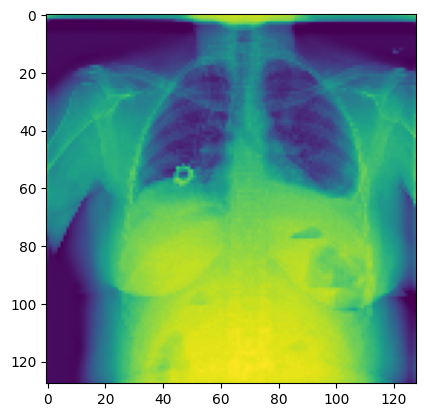

In [16]:
plt.imshow(images[10]);

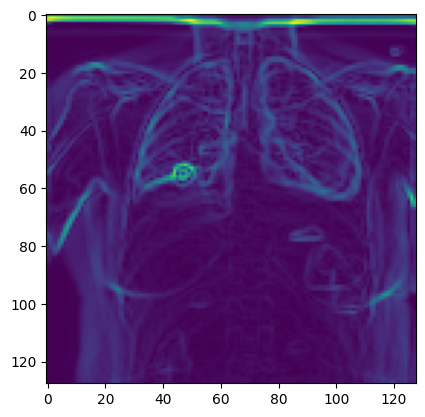

In [17]:
plt.imshow(sobel(images[10]))

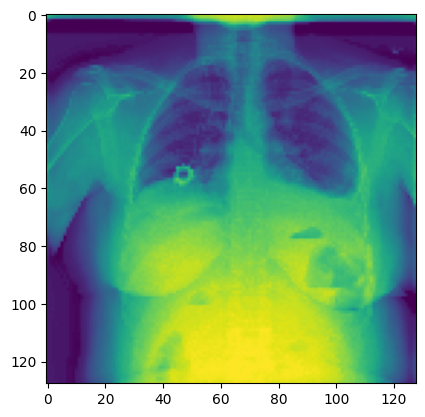

In [18]:
from skimage import exposure

plt.imshow(exposure.equalize_hist(images[10]))

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3577: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


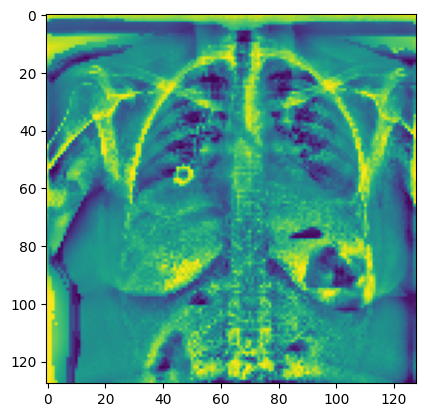

In [19]:
from skimage.morphology import disk
from skimage.filters import rank


footprint = disk(10)
plt.imshow(rank.equalize(images[10]/255, footprint=footprint));

(30752,)


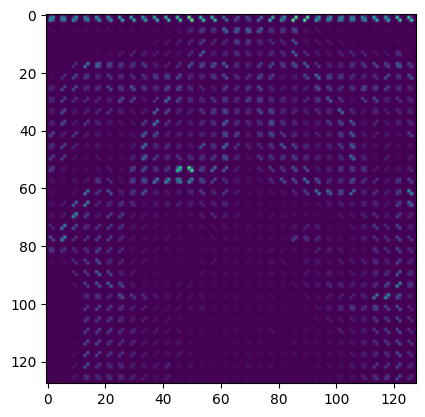

In [20]:
fd, hog_image = hog(
  images[10],
  orientations=8,
  pixels_per_cell=(4, 4),
  cells_per_block=(2, 2),
  visualize=True,
  feature_vector=True
)
print(fd.shape)
plt.imshow(hog_image);

## 3. Обучение модели

In [214]:
images_for_model = preprocess(images, ['orig_img', 'local_equalize_hist', 'hog'])

<ipython-input-214-349070af0958>:1: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  images_for_model = preprocess(images, ['orig_img', 'local_equalize_hist', 'hog'])


In [ ]:
images_for_model.shape

(3000, 98304)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_for_model, labels, test_size=0.33, random_state=SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2010, 98304), (990, 98304), (2010,), (990,))

In [ ]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train)
SVM_pred = SVM_model.predict(X_test)
SVM_pred[:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
accuracy_score(y_test, SVM_pred)  # 0.786 - orig pixels; 0.769 orig + sobel; 0.7712 orig + sobel + gabor; 0.7757 gabor; 0.73131 3000 128 orig sobel gabor;

0.7313131313131314

In [ ]:
recall_score(y_test, SVM_pred)

0.7274549098196392

In [ ]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(max_iter=1000)
LR_model.fit(X_train, y_train)

LR_pred = LR_model.predict(X_test)
LR_pred[:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 0])

In [ ]:
accuracy_score(y_test, LR_pred)  # 0.7545 orig; 0.6363 n=500, size=128, gabor; 0.6303 n=500, size=256, gabor; 0.66565 3000 128 orig sobel gabor;

0.6656565656565656

In [ ]:
recall_score(y_test, LR_pred)

0.6533066132264529

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_jobs=-1, random_state=SEED)
RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
RF_pred[:10]

array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0])

In [ ]:
accuracy_score(y_test, RF_pred)  # 0.73939 500 128x128, orig; 0.7106060 4000 --//--;  0.719191 3000 128 orig sobel gabor;

0.7191919191919192

In [ ]:
recall_score(y_test, RF_pred)

0.6993987975951904

## 4. Оценка и сравнение

In [8]:
def train(img_size=128, n_img=5000, preprocessing_methods_to_use = ['orig_img', 'sobel', 'gabor']):
  SIZE = img_size  # Размер изображения SIZE x SIZE
  N = n_img  # Количество используемых изображений
  logs = {
      'img_size': [],
      'img_number': [],
      'preprocessing': [],
      'model': [],
      'model_params': [],
      'accuracy_score': [],
      'recall_score': [],
      'f1_score': [],
      'f2_score': [],
      'roc_auc_score': [],
  }

  images, labels = init(SIZE=SIZE, N=N)

  images_for_model = preprocess(images, preprocessing_methods_to_use)

  X_train, X_test, y_train, y_test = train_test_split(images_for_model, labels, test_size=0.33, random_state=SEED)

  models_and_params = {
    RandomForestClassifier: [[], {'n_jobs': -1, 'random_state': SEED}],
    LogisticRegression: [[], {'max_iter': 1000}],
    LinearSVC: [[], {'max_iter': 10000, 'random_state': SEED}],
    }
  for model_class, args in models_and_params.items():
    model = model_class(*args[0], **args[1])
    model.fit(X_train, y_train)
    if model_class == LinearSVC:
      pred = model.predict(X_test)
    else:
      pred_proba = model.predict_proba(X_test)[:, 1]
      pred = (pred_proba >= 0.5).astype('int')

    # print(model.classes_)

    # print(pred[:20])
    # print(pred_proba)
    logs['img_size'].append(SIZE)
    logs['img_number'].append(N)
    logs['preprocessing'].append(', '.join(preprocessing_methods_to_use))
    logs['model'].append(str(model_class).split('.')[-1][:-2])
    logs['model_params'].append(str(args))
    logs['accuracy_score'].append(accuracy_score(y_test, pred))
    logs['recall_score'].append(recall_score(y_test, pred))
    logs['f1_score'].append(f1_score(y_test, pred))
    logs['f2_score'].append(fbeta_score(y_test, pred, beta=2))
    logs['roc_auc_score'].append(None if model_class == LinearSVC else roc_auc_score(y_test, pred_proba))

  logs_df = pd.DataFrame(logs)

  header = 'logs.csv' not in os.listdir()
  logs_df.to_csv('logs.csv', mode='a', header=header, index=False)

  return logs_df


In [88]:
methods = [
    ['orig_img', 'sobel', 'gabor'],
    ['orig_img', 'sobel'],
    ['orig_img','gabor'],
    ['sobel', 'gabor'],
    ['gabor'],
    ['orig_img'],
    ['sobel'],
]

for method in methods:
  print(method)
  train(img_size=128, n_img=2000, preprocessing_methods_to_use = method)

['orig_img', 'sobel', 'gabor']
Extracting images from DICOM
['orig_img', 'sobel']
Extracting images from DICOM
['orig_img', 'gabor']
Extracting images from DICOM
['sobel', 'gabor']
Extracting images from DICOM
['gabor']
Extracting images from DICOM
['orig_img']
Extracting images from DICOM
['sobel']
Extracting images from DICOM


In [78]:
from random import randint

random_preds = [randint(0, 1) for _ in range(660)]
accuracy_score(y_test, random_preds)

0.48333333333333334

In [9]:
logs = pd.read_csv('logs.csv')
# logs
logs.sort_values('f2_score', ascending=False)[:30]
# logs.sort_values('f1_score', ascending=False)
# logs.sort_values('roc_auc_score', ascending=False)

# logs[logs['model'] == 'RandomForestClassifier']
# logs[logs['preprocessing'].apply(lambda x: 'pca_size_128_n' in x)]

# logs = logs.drop(logs.index[66:], axis=0)
# logs.to_csv('logs.csv', index=False, mode='w')

,img_size,img_number,preprocessing,model,model_params,accuracy_score,recall_score,f1_score,f2_score,roc_auc_score
19,128,2000,gabor,LogisticRegression,"[[], {'max_iter': 1000}]",0.742424,0.827586,0.738462,0.789474,0.779124
33,128,2000,local_equalize_hist,RandomForestClassifier,"[[], {'n_jobs': -1, 'random_state': 74}]",0.725758,0.803797,0.737300,0.775809,0.781020
15,128,2000,"sobel, gabor",RandomForestClassifier,"[[], {'n_jobs': -1, 'random_state': 74}]",0.727273,0.787879,0.742857,0.769231,0.786961
20,128,2000,gabor,LinearSVC,"[[], {'max_iter': 10000, 'random_state': 74}]",0.727273,0.793103,0.718750,0.761589,NaN
42,128,2000,hog,RandomForestClassifier,"[[], {'n_jobs': -1, 'random_state': 74}]",0.681818,0.784810,0.702550,0.749698,0.763827
1,128,100,sobel,LogisticRegression,"[[], {'max_iter': 1000}]",0.681818,0.807692,0.666667,0.744681,0.711538
63,128,3000,local_equalize_hist,RandomForestClassifier,"[[], {'n_jobs': -1, 'random_state': 74}]",0.696970,0.762948,0.718574,0.744557,0.764914
45,128,3000,"hog, local_equalize_hist, gabor",RandomForestClassifier,"[[], {'n_jobs': -1, 'random_state': 74}]",0.731313,0.737475,0.734531,0.736295,0.786292
39,128,2000,hog,RandomForestClassifier,"[[], {'n_jobs': -1, 'random_state': 74}]",0.712121,0.746177,0.719764,0.735383,0.791663
66,128,5000,pca_size_128_n_1,RandomForestClassifier,"[[], {'n_jobs': -1, 'random_state': 74}]",0.736970,0.729412,0.740741,0.733902,0.809718


In [117]:
train(img_size=128, n_img=2000, preprocessing_methods_to_use = ['equalize_hist'])

Extracting images from DICOM
[0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1]
[0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1]
[0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1]


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,img_size,img_number,preprocessing,model,model_params,accuracy_score,recall_score,f1_score,f2_score,roc_auc_score
0,128,2000,equalize_hist,RandomForestClassifier,"[[], {'n_jobs': -1, 'random_state': 74}]",0.704545,0.733533,0.715328,0.726141,0.765360
1,128,2000,equalize_hist,LogisticRegression,"[[], {'max_iter': 1000}]",0.663636,0.619760,0.650943,0.631868,0.716726
2,128,2000,equalize_hist,LinearSVC,"[[], {'max_iter': 10000, 'random_state': 74}]",0.640909,0.607784,0.631415,0.617021,NaN


In [135]:
train(img_size=128, n_img=2000, preprocessing_methods_to_use = ['local_equalize_hist'])

Extracting images from DICOM


<ipython-input-116-60318c32160b>:19: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  images_for_model = preprocess(images, preprocessing_methods_to_use)
<ipython-input-116-60318c32160b>:19: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  images_for_model = preprocess(images, preprocessing_methods_to_use)
<ipython-input-116-60318c32160b>:19: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  images_for_model = preprocess(images, preprocessing_methods_to_use)
<ipython-input-116-60318c32160b>:19: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by ra

[1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0]
[0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0]
[0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0]


,img_size,img_number,preprocessing,model,model_params,accuracy_score,recall_score,f1_score,f2_score,roc_auc_score
0,128,2000,local_equalize_hist,RandomForestClassifier,"[[], {'n_jobs': -1, 'random_state': 74}]",0.725758,0.803797,0.737300,0.775809,0.78102
1,128,2000,local_equalize_hist,LogisticRegression,"[[], {'max_iter': 1000}]",0.665152,0.699367,0.666667,0.685909,0.69796
2,128,2000,local_equalize_hist,LinearSVC,"[[], {'max_iter': 10000, 'random_state': 74}]",0.634848,0.664557,0.635401,0.652579,NaN


In [172]:
train(img_size=128, n_img=2000, preprocessing_methods_to_use = ['hog', 'gabor', ])

Extracting images from DICOM


,img_size,img_number,preprocessing,model,model_params,accuracy_score,recall_score,f1_score,f2_score,roc_auc_score
0,128,2000,hog,RandomForestClassifier,"[[], {'n_jobs': -1, 'random_state': 74}]",0.681818,0.784810,0.702550,0.749698,0.763827
1,128,2000,hog,LogisticRegression,"[[], {'max_iter': 1000}]",0.689394,0.737342,0.694486,0.719580,0.749522
2,128,2000,hog,LinearSVC,"[[], {'max_iter': 10000, 'random_state': 74}]",0.660606,0.696203,0.662651,0.682382,NaN


In [9]:
methods = [
    ['hog', 'local_equalize_hist', 'gabor'],
    ['hog', 'local_equalize_hist'],
    ['hog','gabor'],
    ['local_equalize_hist', 'gabor'],
    ['gabor'],
    ['hog'],
    ['local_equalize_hist'],
]

for method in methods:
  print(method)
  train(img_size=128, n_img=3000, preprocessing_methods_to_use = method)

['hog', 'local_equalize_hist', 'gabor']
Extracting from .zip
Extracting images from DICOM


C:\Users\user\AppData\Local\Temp\ipykernel_8724\820365980.py:19: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  images_for_model = preprocess(images, preprocessing_methods_to_use)


['hog', 'local_equalize_hist']
Extracting images from DICOM


C:\Users\user\AppData\Local\Temp\ipykernel_8724\820365980.py:19: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  images_for_model = preprocess(images, preprocessing_methods_to_use)


['hog', 'gabor']
Extracting images from DICOM
['local_equalize_hist', 'gabor']
Extracting images from DICOM


C:\Users\user\AppData\Local\Temp\ipykernel_8724\820365980.py:19: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  images_for_model = preprocess(images, preprocessing_methods_to_use)


['gabor']
Extracting images from DICOM
['hog']
Extracting images from DICOM
['local_equalize_hist']
Extracting images from DICOM


C:\Users\user\AppData\Local\Temp\ipykernel_8724\820365980.py:19: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  images_for_model = preprocess(images, preprocessing_methods_to_use)


In [101]:
logs[['img_number', 'model', 'accuracy_score', 'recall_score', 'f1_score', 'f2_score', 'roc_auc_score']].groupby(['img_number', 'model']).apply(np.mean, axis=0)

accuracy_score  recall_score  f1_score  \
img_number model                                                            
100        LinearSVC                     0.651515      0.685897  0.653674   
           LogisticRegression            0.674242      0.711538  0.676190   
           RandomForestClassifier        0.666667      0.698718  0.667563   
2000       LinearSVC                     0.655844      0.664156  0.657195   
           LogisticRegression            0.660173      0.678386  0.665114   
           RandomForestClassifier        0.679654      0.675228  0.675187   

                                   f2_score  roc_auc_score  
img_number model                                            
100        LinearSVC               0.669974            NaN  
           LogisticRegression      0.693196       0.689103  
           RandomForestClassifier  0.683201       0.754223  
2000       LinearSVC               0.660993            NaN  
           LogisticRegression      0.672546       0.699920  
           RandomForestClassifier  0.674247       0.734179

---------------------------------------------------------------
---------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------
---------------------------------------------------------------

In [93]:
X_train.shape

(6700, 2)

In [6]:
images = images.reshape(images.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=SEED)

logs = {
    'img_size': [],
    'img_number': [],
    'preprocessing': [],
    'model': [],
    'model_params': [],
    'accuracy_score': [],
    'recall_score': [],
    'f1_score': [],
    'f2_score': [],
    'roc_auc_score': [],
}
for n_comp in [1, 2, 8, 32, 128]:
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    models_and_params = {
        RandomForestClassifier: [[], {'n_jobs': -1, 'random_state': SEED}],
        # LogisticRegression: [[], {'max_iter': 1000}],
        # LinearSVC: [[], {'max_iter': 1000, 'random_state': SEED}],
    }
    for model_class, args in models_and_params.items():
        model = model_class(*args[0], **args[1])
        print(model_class)
        model.fit(X_train, y_train)
        if model_class == LinearSVC:
            pred = model.predict(X_test)
        else:
            pred_proba = model.predict_proba(X_test)[:, 1]
            pred = (pred_proba >= 0.5).astype('int')

        # print(pred[:20])
        # print(pred_proba)
        logs['img_size'].append(SIZE)
        logs['img_number'].append(N)
        logs['preprocessing'].append('pca_size_128_n_' + str(n_comp))
        logs['model'].append(str(model_class).split('.')[-1][:-2])
        logs['model_params'].append(str(args))
        logs['accuracy_score'].append(accuracy_score(y_test, pred))
        logs['recall_score'].append(recall_score(y_test, pred))
        logs['f1_score'].append(f1_score(y_test, pred))
        logs['f2_score'].append(fbeta_score(y_test, pred, beta=2))
        logs['roc_auc_score'].append(None if model_class == LinearSVC else roc_auc_score(y_test, pred_proba))

logs_df = pd.DataFrame(logs)

header = 'logs.csv' not in os.listdir()
logs_df.to_csv('logs.csv', mode='a', header=header, index=False)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [7]:
logs

{'img_size': [128, 128, 128, 128, 128],
 'img_number': [5000, 5000, 5000, 5000, 5000],
 'preprocessing': ['pca_size_128_n_1',
  'pca_size_128_n_2',
  'pca_size_128_n_8',
  'pca_size_128_n_32',
  'pca_size_128_n_128'],
 'model': ['RandomForestClassifier',
  'RandomForestClassifier',
  'RandomForestClassifier',
  'RandomForestClassifier',
  'RandomForestClassifier'],
 'model_params': ["[[], {'n_jobs': -1, 'random_state': 74}]",
  "[[], {'n_jobs': -1, 'random_state': 74}]",
  "[[], {'n_jobs': -1, 'random_state': 74}]",
  "[[], {'n_jobs': -1, 'random_state': 74}]",
  "[[], {'n_jobs': -1, 'random_state': 74}]"],
 'accuracy_score': [0.7369696969696969,
  0.7369696969696969,
  0.7369696969696969,
  0.7369696969696969,
  0.7369696969696969],
 'recall_score': [np.float64(0.7294117647058823),
  np.float64(0.7294117647058823),
  np.float64(0.7294117647058823),
  np.float64(0.7294117647058823),
  np.float64(0.7294117647058823)],
 'f1_score': [np.float64(0.7407407407407407),
  np.float64(0.74074074

In [ ]:
dcm = pydicom.dcmread("rsna-pneumonia-dataset/stage_2_train_images/dc388ce8-bcdc-4499-9ebc-c494800fab22.dcm")

dcm

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 200
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.4695.1517874309.164794
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4695.1517874309.164794
(0008,0020) Study Date                          DA: '19010101'
(0008,0030) Study Time                    